In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch

from gptopt.optim.attn_kq import *
from gptopt.optim.fast_pdhg import *
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Primal-dual problem pair is 
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G, Z \rangle + \frac{\mu}{2}\|Z\|_F^2 + h(X) \\ 
\text{subject to} & X = \mathcal{A}(Z)
\end{array} 
\iff 
\begin{array}{ll}
{\text{maximize}} &  
-\frac{1}{2\mu}\|\mathcal{A}^*(Y) + G\|_F^2 - h^*(Y)
\end{array} 
$$

## FISTA for dual problem
$$
\begin{align}
Y^{t+1} &= \mathbf{prox}_{\frac{1}{\alpha} h^*}\left (\tilde Y^t - \frac{1}{\alpha\mu} \mathcal{A}(\mathcal{A}^*(\tilde Y^t) + G)\right )\\
\tilde Y^{t+1} &= Y^{t+1} + \frac{k-1}{k+2} ( Y^{t+1} -  Y^t)
\end{align}
$$

In [3]:
for (m, n) in [(20, 40), (40, 20), (40, 40)]:
    for _ in range(5):
        # NumPy data for CVXPY reference
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        beta = 1

        # Torch tensors
        A = torch.from_numpy(A_np).to(torch.float32).to(device)
        B = torch.from_numpy(B_np).to(torch.float32).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

        nA = torch.linalg.norm(A, ord="fro").item()
        nB = torch.linalg.norm(B, ord="fro").item()
        lamb_max = (nA * nA + nB * nB) ** 0.5
        mu_reg = max(1e-2 * lamb_max**2, 1e-6)

        Y0, obj0 = cvxpy_ls_l1_reg(A_np, B_np, G1_np, G2_np, beta, mu=mu_reg)
 
        Y_fista, Z_t, residuals = fista_ls_l1_reg(
                A2=A, A1=B, G1=G1, G2=G2,
                beta=beta, mu=mu_reg, 
                lamb_max=lamb_max, max_iter=10000,
                eps_abs=1e-8, eps_rel=1e-8, stopping=False,
                Y0=None, pd_residuals=pd_residuals_max_ball
            )
        assert residuals["r_rel"][-1] < 1e-4
        Z1, Z2 = Z_t[:m], Z_t[m:]
        assert np.allclose(residuals['dual_vals'][-1], obj0, rtol=1e-4), print(residuals['dual_vals'][-1], obj0)
        
        # primal recovery
        Z1 = Z1.cpu().numpy()
        Z2 = Z2.cpu().numpy()

        Z0_1, Z0_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg)

        #  primal is unique
        assert np.allclose(Z1, Z0_1, atol=1e-3, rtol=1e-3)
        assert np.allclose(Z2, Z0_2, atol=1e-3, rtol=1e-3)
        
        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            np.trace(Z1.T @ G1_np + Z2.T @ G2_np),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.max(np.abs(Z1.T @ B_np + A_np.T @ Z2)) <= beta + 1e-1 and np.max(
            np.abs(Z0_1.T @ B_np + A_np.T @ Z0_2)) <= beta + 1e-1

        # primal recovery via true dual variable
        Z0_1 = (1 / mu_reg) * (- G1_np - B_np @ Y_star.T)
        Z0_2 = (1 / mu_reg) * (- G2_np - A_np @ Y_star)

        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            np.trace(Z1.T @ G1_np + Z2.T @ G2_np),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.max(np.abs(Z1.T @ B_np + A_np.T @ Z2)) <= beta + 1e-1 and np.max(
            np.abs(Z0_1.T @ B_np + A_np.T @ Z0_2)) <= beta + 1e-1
        
print("PASSED")

PASSED


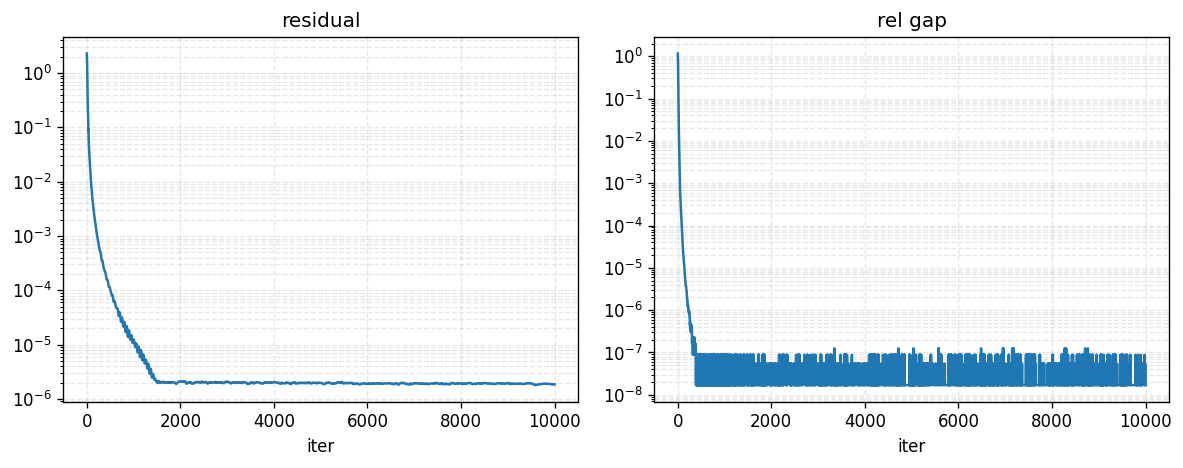

In [9]:
def plot_residuals_and_gap(logging, obj0):
    r = np.array(logging["r_rel"])
    loss = np.array(logging["dual_vals"])
    gap = np.abs(loss - obj0) / max(1.0, abs(obj0))
    it = np.arange(1, len(r) + 1)
   
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)
    ax[0].plot(it, r);    ax[0].set_yscale("log"); ax[0].set_title("residual"); ax[0].set_xlabel("iter")
    ax[1].plot(it, gap);  ax[1].set_yscale("log"); ax[1].set_title("rel gap");  ax[1].set_xlabel("iter")
    for a in ax: a.grid(True, which="both", ls="--", alpha=0.3)
    plt.tight_layout()

    
plot_residuals_and_gap(residuals, obj0)